# Transfer Learning with TensorFlow, Fine-Tuning

In [1]:
# Check for GPU 
!nvidia-smi

Wed Aug 24 20:29:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrithe them all. This is tedious though.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks.

In [2]:
!wget https://raw.githubusercontent.com/JonasHagstrom79/Tensorflow/main/helper.py

--2022-08-24 20:29:14--  https://raw.githubusercontent.com/JonasHagstrom79/Tensorflow/main/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10235 (10.0K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  10.00K  --.-KB/s    in 0s      

2022-08-24 20:29:14 (108 MB/s) - ‘helper.py’ saved [10235/10235]



In [3]:
# Import helper functions we are going to use in this notebook
from helper import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

Using the pretrained models within `tf.keras.applications`

[link here](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

In [4]:
# Get 10% of trainig data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-08-24 20:29:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.234.128, 142.250.152.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.234.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   172MB/s    in 0.9s    

2022-08-24 20:29:19 (172 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [6]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf

# Using image data from directory, all in one hit, no need for image_datagen instance
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # Means that the labels are encoded as a categorical vector (for `categorical_crossentropy` loss), for multiclass data 
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
# tf have turned the data into batches(BatchDataset)
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

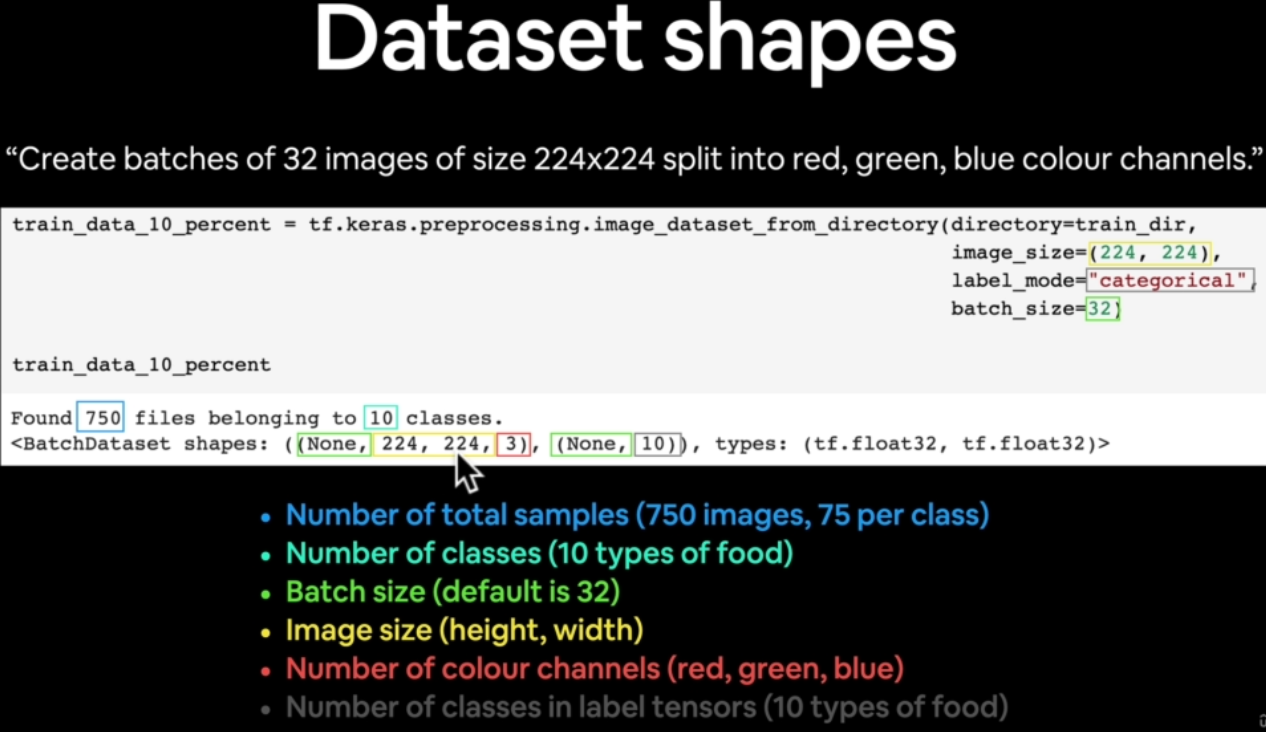

In [9]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[8.05612278e+00 8.05612278e+00 4.13265377e-01]
   [8.64285755e+00 8.64285755e+00 6.42857194e-01]
   [1.03622446e+01 1.03622446e+01 2.36224508e+00]
   ...
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.07144165e+00 1.07144165e+00 1.07144165e+00]
   [2.00000000e+00 2.00000000e+00 2.00000000e+00]]

  [[8.07142830e+00 8.07142830e+00 7.14282990e-02]
   [8.13775444e+00 8.13775444e+00 1.37754589e-01]
   [9.08673477e+00 9.08673477e+00 1.08673441e+00]
   ...
   [1.00000000e+00 1.00000000e+00 0.00000000e+00]
   [2.00000000e+00 2.00000000e+00 0.00000000e+00]
   [2.00000000e+00 2.00000000e+00 0.00000000e+00]]

  [[1.20000000e+01 9.00000000e+00 1.57142830e+00]
   [1.20000000e+01 9.00000000e+00 1.57142830e+00]
   [1.20000000e+01 9.00000000e+00 1.57142830e+00]
   ...
   [2.00000000e+00 3.00000000e+00 0.00000000e+00]
   [2.27041864e+00 3.27041864e+00 0.00000000e+00]
   [3.00000000e+00 4.00000000e+00 0.00000000e+00]]

  ...

  [[8.29439163e+01 4.13011284e+01 1.35153913e+01]
   [7

In [11]:
# Creating a model

ResNet152 = tf.keras.applications.resnet.ResNet152(input_shape=(224, 224, 3),
                                                   include_top=False,
                                                   classes=10)

234708992/234698864 [==============================] - 1s 0us/step


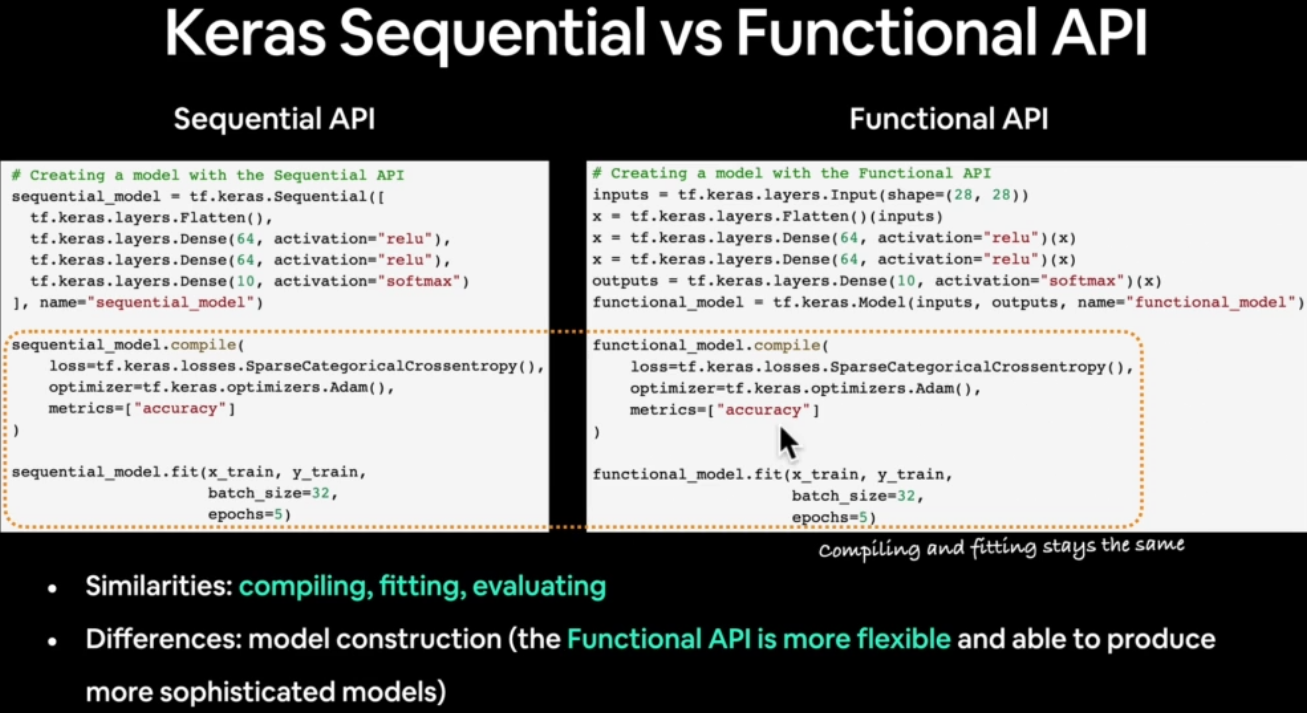

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequentinal API is straight-forward, it runs our layers in sequntial order.

But the functional API gives us more flexibility with our models

In [16]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False,)

# 2. Freeze the base model (so the underlaying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into the model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs 
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Avarage pool the outputs of the base model (aggregate all the most important information, reduce number of computatons)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save it's history
history_model_0 = model_0.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25 *len(test_data)), # Only 25% of the test data for faster training                              )
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="model_0_10_percent_feature_extraction")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/model_0_10_percent_feature_extraction/20220824-205418
Epoch 1/5
24/24 [==============================] - 12s 271ms/step - loss: 1.8564 - accuracy: 0.4227 - val_loss: 1.3143 - val_accuracy: 0.6924
Epoch 2/5
24/24 [==============================] - 4s 160ms/step - loss: 1.1374 - accuracy: 0.7267 - val_loss: 0.9342 - val_accuracy: 0.7796
Epoch 3/5
24/24 [==============================] - 4s 161ms/step - loss: 0.8458 - accuracy: 0.8027 - val_loss: 0.7485 - val_accuracy: 0.8191
Epoch 4/5
24/24 [==============================] - 5s 188ms/step - loss: 0.6915 - accuracy: 0.8480 - val_loss: 0.6550 - val_accuracy: 0.8322
Epoch 5/5
24/24 [==============================] - 5s 188ms/step - loss: 0.5935 - accuracy: 0.8600 - val_loss: 0.6113 - val_accuracy: 0.8289


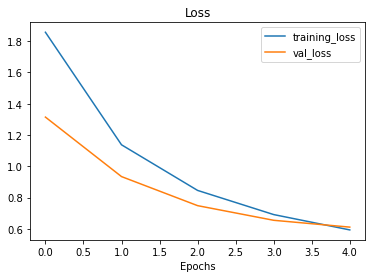

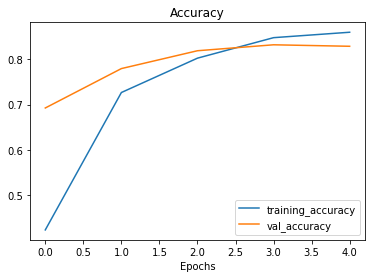

In [17]:
plot_loss_curves(history_model_0)

In [18]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.6158 - accuracy: 0.8348


[0.6157777905464172, 0.8348000049591064]

In [19]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_4
1 rescaling_2
2 normalization_2
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [21]:
# Summary of the base_model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_2 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

In [22]:
# Summary of our whole model
model_0.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [30]:
# GlobalAveragePooling2D is transforming a 4d tensor into a 2d tensor

# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")
print("It removes the two inner-axis:es")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)
It removes the two inner-axis:es


In [31]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2]) # the same result as in the above cell

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

### ⚒**Practice:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D` and see what happens.

In [32]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_shape}\n")

# Pass the random tensor through a global max pooling 2D layer
global_max_pooled_tensor = tf.keras.layers.MaxPooling2D()(input_tensor)
print(f"2D global max pooled random tensor:\n {global_max_pooled_tensor}\n")

# Check the shape of the differet tensor
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Max Pooled 2D tensor: {global_max_pooled_tensor.shape}")

Random input tensor:
 (1, 4, 4, 3)

2D global max pooled random tensor:
 [[[[ 0.8504023  -0.40604794  0.3194337 ]
   [ 0.9058464   0.539707    1.6994323 ]]

  [[ 0.77852213  0.4012578   0.97772694]
   [ 0.32410017  1.1603122   0.52744764]]]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Max Pooled 2D tensor: (1, 2, 2, 3)
